<a href="https://colab.research.google.com/github/NosenkoArtem/Categorical-Encoding/blob/master/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80_%E2%84%961_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### План


- Введение: определение модели и пространство вероятностей.
- Оценка методом максимального правдоподобия (MLE) для среднеквадратичной ошибки (MSE): аналитическое решение против Autograd.
- Оценка методом максимального правдоподобия для распределения Пуассона: метод Ньютона—Рафсона.

### Обсуждение: что такое модель?

Для начала обсудим следующее. Что такое модель? Какое определение для модели мы дадим?

## 1. Определение модели и оценка максимального правдоподобия
## ( Maximum Liklihood Estimation — MLE )

В целом процедура оценки модели включает выбор значений параметров модели таким образом, чтобы модель соответствовала некоторому количеству характеристик или свойств данных.
<br>
Процедуры оценки можно в целом классифицировать по критериям, согласно которым они выбирают эти параметры модели.
<br>
Например:
- 1) Метод наименьших квадратов (МНК) относится к классу процедур оценки, которые минимизируют квадратичные ошибки.
- 2) Методы моментов (например, обобщенный метод моментов или) используют статистические моменты (например, среднее значение) и пытаются сопоставить моменты модели с моментами данных.
- 3) Метод максимального правдоподобия, как мы обсудим в этом семинаре, выбирает параметры, максимизируя «функцию правдоподобия», что можно интерпретировать как выбор параметров модели таким образом, чтобы вероятность того, что эта модель произведет заданные данные, была бы максимальной.
<br>
Для начала давайте более подробно обсудим, что мы подразумеваем под моделью.

### Что такое модель?

#### Мы не будем говорить про все модели в общем, а поговорим только про некоторые вероятностные или статистические модели.

Статистические модели — это инструменты, помогающие нам обобщать сложные данные. Модель обычно пытается быть упрощенным, но полезным представлением мира. Из [Википедии](https://en.wikipedia.org/wiki/Statistical_model):

> Статистическая модель — это математическая модель, которая воплощает набор статистических предположений относительно **генерации некоторых выборочных данных** и аналогичных данных из более крупной совокупности. Статистическая модель представляет, часто в значительно идеализированной форме, процесс генерации данных.
>
> Предположения, воплощенные статистической моделью, описывают набор распределений вероятностей, некоторые из которых, как предполагается, адекватно приближают распределение, из которого выбирается конкретный набор данных.

Важной частью тех моделей, с которыми мы будем работать, являются распределения вероятностей.

Математически статистическая модель — это просто набор распределений вероятностей. Если быть точным, [статистическая модель обычно определяется ](https://en.wikipedia.org/wiki/Statistical_model#Formal_definition)
> как пара $(\Omega, \mathcal P)$, где $\Omega$ — это множество возможных наблюдений, то есть выборочное пространство, а $\mathcal P$ — это множество распределений вероятностей на $\Omega$.

Обратите внимание, что это определение почти совпадает с [определением вероятностного пространства:](https://en.wikipedia.org/wiki/Probability_space)

> В теории вероятностей вероятностное пространство или вероятностное путешествие $(\Omega, \mathfrak{A}, P)$ — это математическая конструкция, которая моделирует реальный процесс (или «эксперимент»), состоящий из состояний, которые происходят случайным образом. ...
Вероятностное пространство состоит из трех частей:
>
> 1. Пространство выборок, $\Omega$, которое является множеством всех возможных результатов.
> 2. Множество событий $\mathfrak{A}$, где каждое событие является множеством, содержащим ноль или более результатов.
> 3. Назначение вероятности событиям; то есть функция $P$ от событий к вероятностям.

**Более формально:**

> $\Omega$ — произвольное непустое множество, элементы которого называются элементарными событиями, исходами или точками;

> $\mathfrak{A}$ — сигма-алгебра подмножеств $\Omega$, называемых (случайными) событиями;

> $\mathbb{P}$ — вероятностная мера или вероятность, то есть сигма-аддитивная конечная мера такая, что $\mathbb{P}(\Omega) = 1$.

Разница здесь в том, что статистическая модель определяется как *множество* распределений вероятностей. Таким образом, существует множество распределений вероятностей $P \in \mathcal P$.

По большей части множество $\mathcal P$ параметризовано: $\mathcal P = \{P_\theta : \theta \in \Theta\}$, где $\Theta$ определяет множество возможных конфигураций параметров модели.

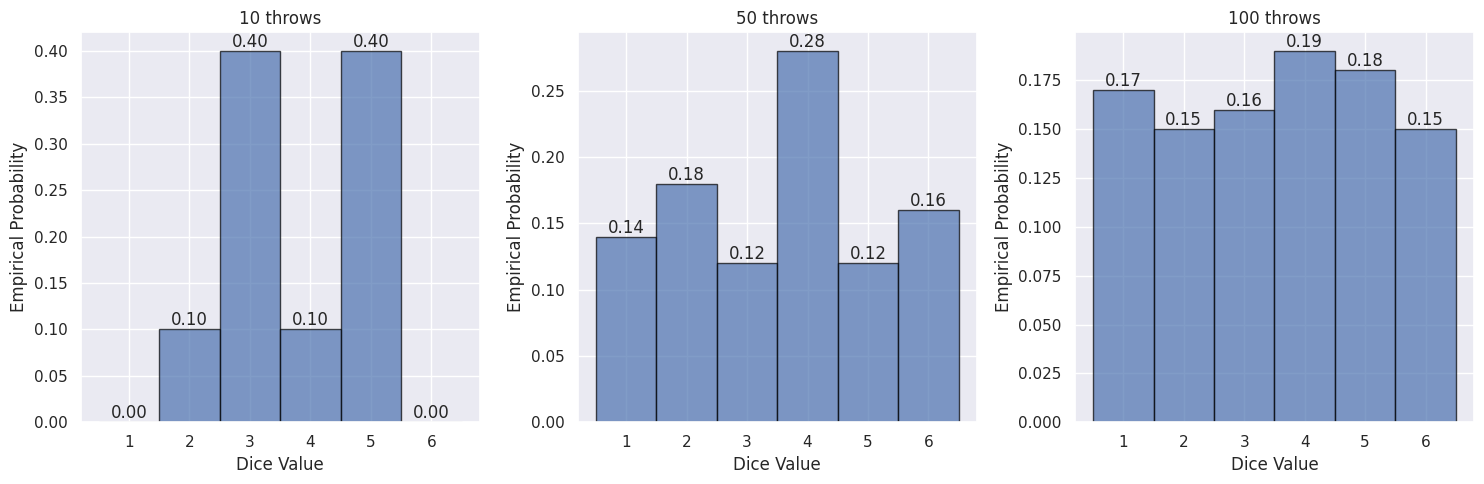

In [ ]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy.stats as stats
import pandas as pd
sns.set()

# Function to simulate dice throws and plot the results
def simulate_and_plot_dice_throws(num_throws_list):
    np.random.seed(42)  # For reproducibility

    fig, axes = plt.subplots(1, len(num_throws_list), figsize=(15, 5))

    for i, num_throws in enumerate(num_throws_list):
        throws = np.random.randint(1, 7, num_throws)
        bins = np.arange(1, 8) - 0.5

        # Calculate empirical probabilities
        counts, _ = np.histogram(throws, bins=bins)
        empirical_probabilities = counts / num_throws

        axes[i].hist(throws, bins=bins, edgecolor='black', alpha=0.7, density=True)
        axes[i].set_title(f'{num_throws} throws')
        axes[i].set_xlabel('Dice Value')
        axes[i].set_ylabel('Empirical Probability')
        axes[i].set_xticks(range(1, 7))

        # Display empirical probabilities on the plot
        for j in range(1, 7):
            axes[i].text(j, empirical_probabilities[j-1], f'{empirical_probabilities[j-1]:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Number of throws to simulate
num_throws_list = [10, 50, 100]

# Simulate and plot the dice throws
simulate_and_plot_dice_throws(num_throws_list)

### Оценка максимального правдоподобия (MLE)


Оценку максимального правдоподобия часто называют фундаментальным принципом оценки, отдельно от, например, метода моментов. Оценка максимального правдоподобия является частным случаем оценки экстремума — оценки, которая получается путем максимизации, как функции параметров $\theta$, целевой функции (ср. функцию потерь) $ \hat {\ell }(\theta \,;x) = \hat {\ell }(\theta \,;x)$. Если данные независимы и одинаково распределены, то имеем

$${\hat {\ell }}(\theta \,;x)={\frac {1}{n}}\sum _{i=1}^{n}\ln f(x_{i}\mid \theta ),$$

это является  оценкой матожидания логарифма правдоподобия $\ell (\theta )=\operatorname {E} [\,\ln f(x_{i}\mid \theta )\,]$, где ожидание берется относительно истинной плотности.

MLE можно применять к чрезвычайно широкому спектру моделей, от простых до очень сложных.


Целью метода максимального правдоподобия (MLE) является выбор вектора параметров модели $\theta$ для максимизации правдоподобия наблюдения данных:  $(x_1, x_2, \ldots, x_J)$.

<br>
Простым примером модели является статистическое распределение; например, нормальное распределение $N(\mu, \sigma)$
<br>
<br>
$$ f(x|\theta) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left\{-\frac{(x - \mu)^2}{2\sigma^2}\right\} .$$

<br>
<br>

> Плотность вероятности извлечения одного значения $x_i$ из распределения **модели** $f(x|\theta)$ равна $f(x_i|\theta)$.

> Плотность вероятности извлечения двух наблюдений $(x_1,x_2)$ из распределения **модели** $f(x|\theta)$ равна $f(x_1|\theta)\times f(x_2|\theta)$.

> Для трех наблюдений $f(x_1|\theta)\times f(x_2|\theta)\times f(x_3|\theta).$

<br>

Мы определяем функцию правдоподобия $N$ извлечений $(x_1,x_2,\ldots,x_N)$ из модели или распределения $f(x|\theta)$ как $L$:

$$ L(x_1,x_2,\ldots,x_N|\theta) \equiv \prod_{i=1}^N f(x_i|\theta). $$

Поскольку численно сложно максимизировать произведение, почти всегда проще использовать функцию логарифма правдоподобия $\ell = \ln(L)$:

$$ \ell(x_1,x_2,\ldots,x_N|\theta) \equiv \sum_{i=1}^N \ln\Bigl(f(x_i|\theta)\Bigr) .$$

Оценка максимального правдоподобия $\hat{\theta}_{MLE}$ определяется следующим образом:

$$ \hat{\theta}_{MLE} = \arg \max_\theta \:  \ell(x_1,x_2,\ldots,x_N|\theta). $$

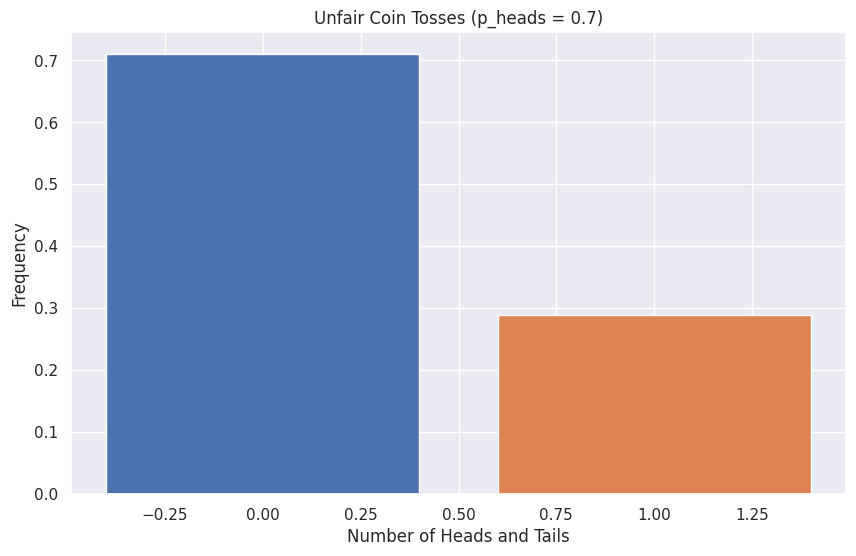

In [ ]:
def simulate_unfair_coin_tosses(p_heads, n_tosses):
    """
    Simulate unfair coin tosses and plot the outcomes.

    Parameters:
    p_heads (float): Probability of heads (0 < p_heads < 1).
    n_tosses (int): Number of coin tosses in each simulation.
    n_simulations (int): Number of simulations to perform.
    """
    # Simulate the coin tosses
    outcomes = np.random.binomial(n=1, p=p_heads, size=(1, n_tosses))

    # Calculate the number of heads in each simulation
    num_heads = np.sum(outcomes, axis=1)

    # Plot the outcomes
    plt.figure(figsize=(10, 6))
    plt.bar(0,outcomes.mean())
    plt.bar(1,1-outcomes.mean())
    plt.xlabel('Number of Heads and Tails')
    plt.ylabel('Frequency')
    plt.title(f'Unfair Coin Tosses (p_heads = {p_heads})')
    plt.grid(True)
    plt.show()

    return outcomes

# Example usage
p_heads = 0.7  # Probability of heads
n_tosses = 100  # Number of coin tosses in each simulation


outcomes = simulate_unfair_coin_tosses(p_heads, n_tosses)

### А теперь подберем параметры функции руками, минимизируя MLE.

В этой задаче и так все понятно, но сделаем это для наглядности.

$$L(outcomes \mid p_{heads}) = \prod_{i=1}^{n} p_{heads}^{outcomes_i} \cdot (1 - p_{heads})^{1 - outcomes_i}.$$

Text(0, 0.5, 'NLL - Negative Log Liklihood')

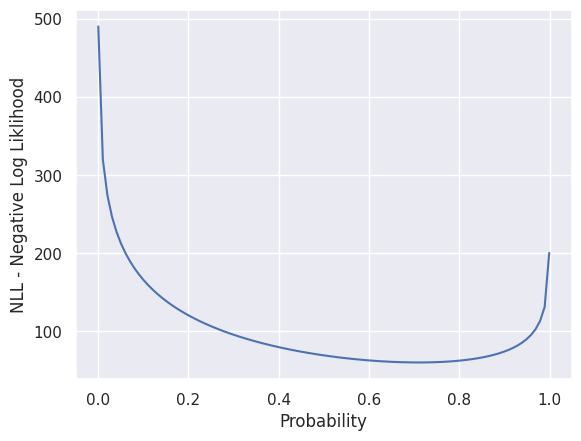

In [ ]:
def compute_likelihood(outcomes, p_heads):
    """
    Compute the likelihood of the outcomes of unfair coin tosses.

    Parameters:
    outcomes (np.ndarray): A 2D array of coin toss outcomes, where each row represents a simulation.
    p_heads (float): Probability of heads (0 < p_heads < 1).

    Returns:
    float: The likelihood of the outcomes.
    """
    # Calculate the likelihood of each simulation
    total_likelihood = np.log(p_heads**outcomes * (1 - p_heads)**(1 - outcomes)).sum()

    return total_likelihood



liklihoods = []

steps = np.linspace(0.001,0.999,100)

for step in steps:
    liklihoods.append(-compute_likelihood(outcomes, p_heads=step))

plt.plot(steps, liklihoods)

plt.xlabel('Probability')
plt.ylabel('NLL - Negative Log Liklihood')

В этом примере мы видим, что хотим минимизировать Negative Log Liklihood или максимизировать Log Liklihood, но не всегда это сделать просто, в данном случае у нас был всего один параметер для генерации нашего распределения, параметров может больше, а наши данные могут быть более сложными.

Тем не менее рассмотрим еще несколько простых примеров, когда мы можем оценить параметры модели явно с помощю MLE.

Для нормального распределения $N(\mu, \sigma^2)$, функция плотности вероятности (PDF) равна

$$ f(x \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right) .$$

Для выборки из $n$ наблюдений $\{x_1, x_2, \ldots, x_n\}$ функция правдоподобия $L$ равна

$$ L(x_1, x_2, \ldots, x_n \mid \mu, \sigma^2) = \prod_{i=1}^n f(x_i \mid \mu, \sigma^2) .$$

Беря натуральный логарифм функции правдоподобия, получаем функцию логарифма правдоподобия:

$$ \ell(x_1, x_2, \ldots, x_n \mid \mu, \sigma^2) = \sum_{i=1}^n \ln\left(f(x_i \mid \mu, \sigma^2)\right). $$

Подставим PDF в функцию логарифма правдоподобия:

$$ \ell(x_1, x_2, \ldots, x_n \mid \mu, \sigma^2) = \sum_{i=1}^n \left[ -\frac{1}{2}\ln(2\pi\sigma^2) - \frac{(x_i - \mu)^2}{2\sigma^2} \right]. $$

Упростим функцию логарифма правдоподобия:

$$ \ell(x_1, x_2, \ldots, x_n \mid \mu, \sigma^2) = -\frac{n}{2}\ln(2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (x_i - \mu)^2 .$$

### MLE для $\mu$

Чтобы найти MLE для параметра $\mu$, возьмем частную производную функции логарифма правдоподобия по $\mu$ и приравниваем ее нулю:

$$ \frac{\partial \ell}{\partial \mu} = \frac{1}{\sigma^2} \sum_{i=1}^n (x_i - \mu) = 0 .$$

Решим уравнение относительно $\mu$:

$$ \sum_{i=1}^n x_i - n\mu = 0 ,$$

$$ \mu = \frac{1}{n} \sum_{i=1}^n x_i .$$

Таким образом, MLE для $\mu$ является выборочным средним:

$$ \hat{\mu} = \bar{x} = \frac{1}{n} \sum_{i=1}^n x_i .$$

### MLE для $\sigma^2$

Чтобы найти MLE для $\sigma^2$, возьмем частную производную функции логарифма правдоподобия по $\sigma^2$ и приравняем ее нулю:

$$ \frac{\partial \ell}{\partial \sigma^2} = -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4} \sum_{i=1}^n (x_i - \mu)^2 = 0 .$$

Решим уравнение относительно $\sigma^2$:

$$ -\frac{n}{2\sigma^2} + \frac{1}{2\sigma^4} \sum_{i=1}^n (x_i - \mu)^2 = 0, $$

$$ \frac{n}{\sigma^2} = \frac{1}{\sigma^4} \sum_{i=1}^n (x_i - \mu)^2, $$

$$ \sigma^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \mu)^2 .$$

Таким образом, MLE для $\sigma^2$ равна

$$ \hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2 .$$


Таким образом, в некоторых случаях мы можем оценить параметры нашей модели достаточно просто. Однако всё зависит от модели и сложности данных.

<br>

Сгенерируем данные с известными параметрами и оценим их получившимися формулами.

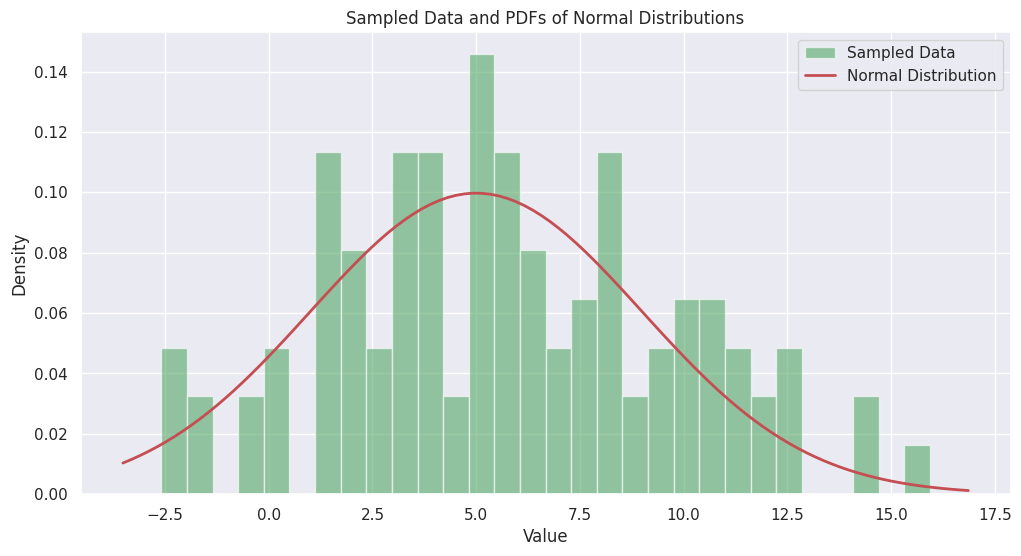

In [ ]:
# Насемплируем некоторые данные:

def gen_data(mu_1=0, sigma_1=1, mu_2=0, sigma_2=1, proportion=0.3, n=1000):
    data = np.zeros(n)
    for i in range(n):
        if np.random.rand() < proportion:
            data[i] = np.random.normal(loc=mu_1, scale=sigma_1)
        else:
            data[i] = np.random.normal(loc=mu_2, scale=sigma_2)
    return data


# Parameters for the normal distributions
mu_1 = 5
sigma_1 = 4
n = 100

# Generate data
data = gen_data(mu_1, sigma_1, 0, 0, 1, n)

# Plot the sampled data
plt.figure(figsize=(12, 6))

# Histogram of the sampled data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Sampled Data')

# Plot the PDFs of the two normal distributions
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = stats.norm.pdf(x, mu_1, sigma_1)
plt.plot(x, p1, 'r', linewidth=2, label='Normal Distribution')


# Add labels and legend
plt.title('Sampled Data and PDFs of Normal Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

In [ ]:
print(f'оценочное mu: {data.mean()}, оценочное sigma: {data.std()}')

оценочное mu: 5.7295503098663, оценочное sigma: 4.02354289635474


## А что, если у нас знакомая задача регрессии?

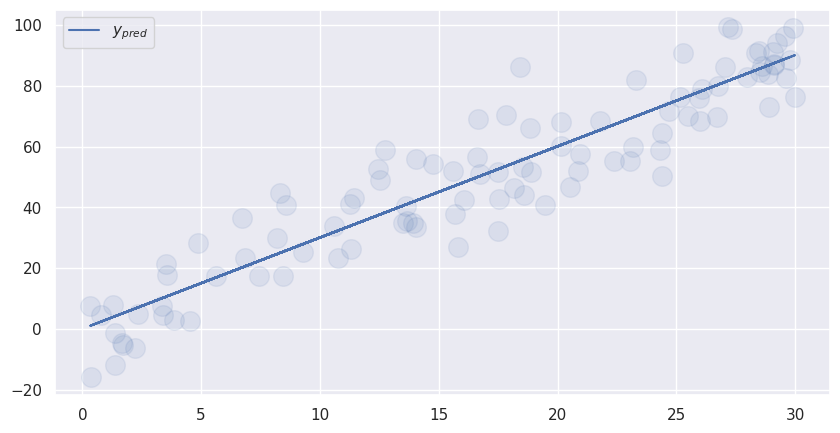

In [ ]:
X = np.random.rand(100) * 30
y = X * 3 + 0.1
y_noisy = y + np.random.normal(scale=10, size=X.shape)



plt.figure(figsize=(10,5))
plt.scatter(X, y_noisy, s=200, c='b', alpha=0.1)
y_hat = X * 3 + 0.1
plt.plot(X, y_hat, label='$y_{pred}$')


plt.legend();

### MLE для задачи регрессии

Предполагаем, что данные из нормального распределения.
Допустим у нас есть некоторая модель:

$$ y =  \beta_0 + \beta_1*x_1 + \beta_2*x_2 + \ldots + \beta_n*x_n + \epsilon ,$$

$$ \epsilon \sim N(0, \sigma^2) .$$

Оценка $\beta_0, \beta_1, \ldots, \beta_p$ с использованием обучающих данных является задачей оптимизации, которую можно решить с помощью метода максимального правдоподобия (MLE).

Предположим, что $\epsilon$ имеет нормальное распределение $\epsilon \sim N(0, \sigma^2)$, тогда наша целевая переменная $y$ также будет иметь нормальное распределение. Таким образом, $y \sim N(\beta^T x, \sigma^2)$. Функция плотности вероятности нормального распределения с параметрами $\mu$ (среднее) и $\sigma^2$ (дисперсия) задается следующим образом:

$$ f(y \mid \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y - \mu)^2}{2\sigma^2}\right) . $$

Следовательно, если мы заменим параметр $\mu$ на среднее значение $y$, получим

$$ f(y \mid \beta^T x, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y - \beta^T x)^2}{2\sigma^2}\right)  .$$

Функция логарифма правдоподобия будет следующей:

$$ \log(L(\beta \mid x^{(1)}, x^{(2)}, \ldots, x^{(n)})) = \sum_{i=1}^n \log\left(\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y - \beta^T x^{(i)})^2}{2\sigma^2}\right)\right) = n \log\left(\frac{1}{\sqrt{2\pi\sigma^2}}\right) - \sum_{i=1}^n \frac{(y - \beta^T x^{(i)})^2}{2\sigma^2} .$$

Поскольку нам нужно взять производную функции логарифма правдоподобия по $\beta$, чтобы найти оценку максимального правдоподобия для $\beta$, мы можем удалить все члены, которые не содержат наш параметр $\beta$, так как они не оказывают влияния на нашу оптимизацию. Таким образом, наше уравнение приобретает вид
$$ \log(L(\beta \mid x^{(1)}, x^{(2)}, \ldots, x^{(n)})) = -\sum_{i=1}^n \frac{(y - \beta^T x^{(i)})^2}{2\sigma^2} = -\sum_{i=1}^n (y - \hat{y}^{(i)})^2  .$$

Значение $\beta$, которое максимизирует это выражение, является оценкой максимального правдоподобия $\hat{\beta}_{MSE}$. То есть

$$ \hat{\beta}_{MSE} = \arg\max_{\beta} \left[ -\sum_{i=1}^n (y - \hat{y}^{(i)})^2 \right]  .$$

Напомним, что максимизация функции эквивалентна минимизации ее же со знаком минус, поэтому мы можем переписать оценку следующим образом:

$$ \hat{\beta}_{MSE} = \arg\max_{\beta} \left[ -\sum_{i=1}^n (y - \hat{y}^{(i)})^2 \right] = \arg\min_{\beta} \sum_{i=1}^n (y - \hat{y}^{(i)})^2 .$$

Усредняя по всем $n$ обучающим примерам, получаем:

$$ \hat{\beta}_{MSE} = \arg\min_{\beta} \sum_{i=1}^n (y - \hat{y}^{(i)})^2 . $$

Тут можно остановиться и использовать MSE для того, чтобы найти нужные параметры различными алгоритмами, например с помощью SGD.

Но можно пойти на шаг дальше и получить решение для параметра $\beta$, допустим $\beta$ размерностью 1. Для этого возьмем производную по $\beta$, приравняем к нулю и получим явное решение:

$$ \frac{\delta MSE}{\delta \beta} = 2 \sum_{i=1}^N (y^{(i)} - \beta x^{(i)}) x^{(i)} = 0 ,$$

$$  \sum_{i=1}^N (y^{(i)} -  \beta x^{(i)})x^{(i)} = \beta  \sum_{i=1}^N x^{(i)2} -  \sum_{i=1}^N x_i y_i = 0 ,$$

$$ \hat{\beta}_{MSE} = \frac{\sum_{i=1}^N x^{(i)} y{(i)}}{\sum_{i=1}^N x_i^2} . $$



In [ ]:
beta_estimated = (y_noisy*X).sum()/(X**2).sum()

print(f'Оценочный beta: {beta_estimated}, реальный scale: {3}')

Оценочный beta: 2.9753197132170524, реальный scale: 3


# Домашнее задание 1

Хоть нормальное распределение и встречается часто, но не всегда все так просто, наши распределения на самом деле гораздо сложнее. Для задачи ниже мы могли использовать [смесь нормальных распределений](https://en.wikipedia.org/wiki/Mixture_model).


А теперь вопрос, можно ли это решить с помощю градиентнов и pytorch? Заготовка решения у вас есть, а проработать и ответить на этот вопрос можно будет самостоятельно!

Это бонусное задание, основное задание будет ниже.

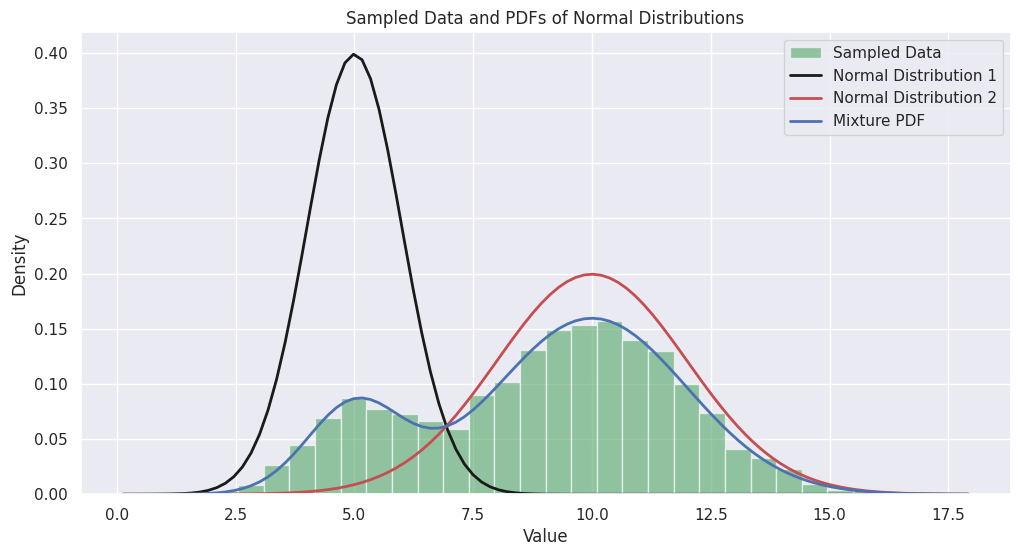

In [ ]:
#Parameters for the normal distributions
mu_1 = 5
sigma_1 = 1
mu_2 = 10
sigma_2 = 2
proportion = 0.2
n = 10000

# Generate data
data = gen_data(mu_1, sigma_1, mu_2, sigma_2, proportion, n)

# Plot the sampled data
plt.figure(figsize=(12, 6))

# Histogram of the sampled data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Sampled Data')

# Plot the PDFs of the two normal distributions
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = stats.norm.pdf(x, mu_1, sigma_1)
p2 = stats.norm.pdf(x, mu_2, sigma_2)
plt.plot(x, p1, 'k', linewidth=2, label='Normal Distribution 1')
plt.plot(x, p2, 'r', linewidth=2, label='Normal Distribution 2')

# Plot the mixture PDF
mixture_pdf = proportion * p1 + (1 - proportion) * p2
plt.plot(x, mixture_pdf, 'b', linewidth=2, label='Mixture PDF')

# Add labels and legend
plt.title('Sampled Data and PDFs of Normal Distributions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

## Заготовка для самостоятельного решения

Можете менять все, что угодно. Самое важное, чтобы оцененые параметры в итоге были такими же.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class MixtureModel(nn.Module):
    def __init__(self):
        super(MixtureModel, self).__init__()
        self.mu_1 = nn.Parameter(torch.tensor(0.0))
        self.sigma_1 = nn.Parameter(torch.tensor(1.0))
        self.mu_2 = nn.Parameter(torch.tensor(0.0))
        self.sigma_2 = nn.Parameter(torch.tensor(1.0))
        self.proportion = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):

        # TODO

        p1 = torch.exp(-(x - self.mu_1)**2 / (2 * self.sigma_1**2)) / (self.sigma_1 * torch.sqrt(2 * torch.tensor(np.pi)))
        p2 = torch.exp(-(x - self.mu_2)**2 / (2 * self.sigma_2**2)) / (self.sigma_2 * torch.sqrt(2 * torch.tensor(np.pi)))
        mixture_pdf = torch.abs(self.proportion) * p1 + torch.abs(1 - self.proportion) * p2
        return mixture_pdf

# Convert data to PyTorch tensor
data_tensor = torch.tensor(data, dtype=torch.float32)

# Initialize the model, loss function, and optimizer
model = MixtureModel()
criterion = # TODO
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1
batch_size = 1000
for epoch in range(num_epochs):
    # Forward pass
    indices = torch.randperm(data_tensor.size(0))[:batch_size]
    outputs = model(data_tensor[indices])
    loss = # TODO

    # Backward pass and optimization
    optimizer.zero_grad()



    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Print the estimated parameters
print(f'Estimated mu_1: {model.mu_1.item():.4f}')
print(f'Estimated sigma_1: {model.sigma_1.item():.4f}')
print(f'Estimated mu_2: {model.mu_2.item():.4f}')
print(f'Estimated sigma_2: {model.sigma_2.item():.4f}')
print(f'Estimated proportion: {model.proportion.item():.4f}')

Epoch [100/1000], Loss: 0.0000
Epoch [200/1000], Loss: 0.0000
Epoch [300/1000], Loss: 0.0000
Epoch [400/1000], Loss: 0.0000
Epoch [500/1000], Loss: 0.0000
Epoch [600/1000], Loss: 0.0000
Epoch [700/1000], Loss: 0.0000
Epoch [800/1000], Loss: 0.0000
Epoch [900/1000], Loss: 0.0000
Epoch [1000/1000], Loss: 0.0000
Estimated mu_1: -0.0676
Estimated sigma_1: 0.9304
Estimated mu_2: -0.2891
Estimated sigma_2: 0.6689
Estimated proportion: 0.0002


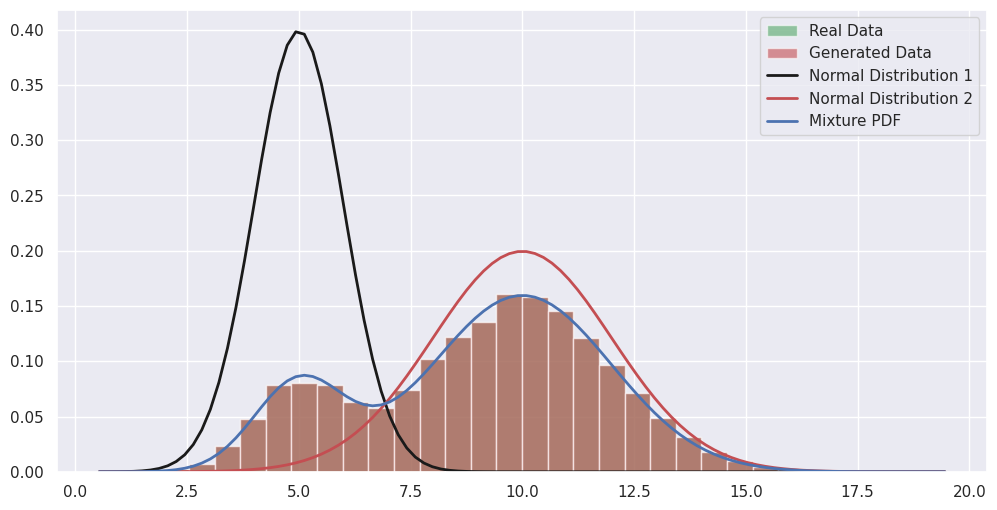

In [ ]:
# Generate data
data_gen = gen_data(model.mu_1.item(), model.sigma_1.item(), model.mu_2.item(), model.sigma_2.item(), model.proportion.item(), n)

data = gen_data(mu_1, sigma_1, mu_2, sigma_2, proportion, n)

# Plot the sampled data
plt.figure(figsize=(12, 6))

# Histogram of the sampled data
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Real Data')

plt.hist(data_gen, bins=30, density=True, alpha=0.6, color='r', label='Generated Data')

# Plot the PDFs of the two normal distributions
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = stats.norm.pdf(x, model.mu_1.item(), model.sigma_1.item())
p2 = stats.norm.pdf(x, model.mu_2.item(), model.sigma_1.item())
plt.plot(x, p1, 'k', linewidth=2, label='Normal Distribution 1')
plt.plot(x, p2, 'r', linewidth=2, label='Normal Distribution 2')

# Plot the mixture PDF
mixture_pdf = proportion * p1 + (1 - proportion) * p2
plt.plot(x, mixture_pdf, 'b', linewidth=2, label='Mixture PDF')
plt.legend()

### А тем временем мы разберем другой сложный пример

Здесь мы иллюстрируем максимальное правдоподобие, повторяя статью Дэниела Трейсмана (2016) [Российские миллиардеры](https://www.aeaweb.org/articles?id=10.1257/aer.p20161068), которая связывает количество миллиардеров в стране с ее экономическими характеристиками.

В статье делается вывод, что в России больше миллиардеров, чем предсказывают экономические факторы, такие как размер рынка и налоговая ставка.

Нам потребуется следующий импорт:

In [ ]:
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col

### Основные идеи

Первым шагом при оценке максимального правдоподобия является выбор распределения вероятностей, которое, как предполагается, **генерирует данные.**

Точнее, нам нужно сделать предположение о том, какой **параметрический класс** распределений генерирует данные.

Например, класс всех нормальных распределений или класс всех гамма-распределений.

Каждый такой класс представляет собой семейство распределений, индексированных конечным числом параметров.

Например, класс нормальных распределений представляет собой семейство распределений, индексированных своими средним $ \mu \in (-\infty, \infty) $ и стандартным отклонением $ \sigma \in (0, \infty) $.

Мы позволим данным выбрать наши параметры, закрепив таким образом класс распределения.

Полученные таким образом оценки параметров будут называться **оценками максимального правдоподобия**.

### Подсчет миллиардеров

Трейсман [[Трейсман, 2016](https://python.quantecon.org/zreferences.html#id95)] интересуется оценкой количества миллиардеров в разных странах.

Количество миллиардеров — целое число. Поэтому мы рассматриваем распределения, которые принимают значения только в неотрицательных целых числах.

(Это одна из причин, по которой регрессия наименьших квадратов не является лучшим инструментом для данной проблемы, поскольку зависимая переменная в линейной регрессии не ограничена целыми значениями.)

Одним из целочисленных распределений является [распределение Пуассона](https://en.wikipedia.org/wiki/Poisson_distribution), функция вероятности (pmf — probability mass function) которого равна

$$
f(y) = \frac{\mu^{y}}{y!} e^{-\mu},
\qquad y = 0, 1, 2, \ldots, \infty.
$$

Мы можем построить распределение Пуассона по $ y $ для различных значений $ \mu $ следующим образом:

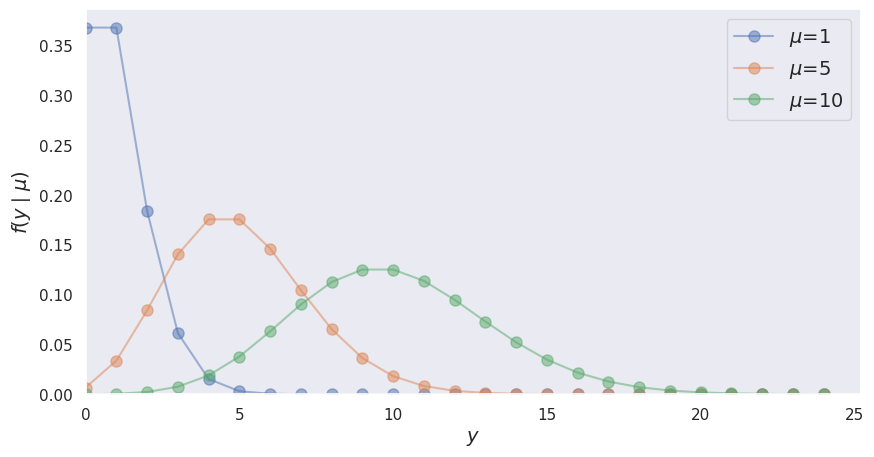

In [ ]:
poisson_pmf = lambda y, μ: μ**y / factorial(y) * np.exp(-μ)
y_values = range(0, 25)

fig, ax = plt.subplots(figsize=(10, 5))

for μ in [1, 5, 10]:
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu$={μ}',
            alpha=0.5,
            marker='o',
            markersize=8)

ax.grid()
ax.set_xlabel('$y$', fontsize=14)
ax.set_ylabel('$f(y \mid \mu)$', fontsize=14)
ax.axis(xmin=0, ymin=0)
ax.legend(fontsize=14)

plt.show()

Обратите внимание, что распределение Пуассона начинает напоминать нормальное распределение по мере увеличения среднего значения $ y $.

Давайте посмотрим на распределение данных, с которыми мы будем работать.

Основным источником данных Трейсмана являются ежегодные рейтинги миллиардеров *Forbes* и их предполагаемая чистая стоимость.

Набор данных `mle/fp.dta` можно загрузить [здесь](https://python.quantecon.org/_static/lecture_specific/mle/fp.dta)
или с его [страницы AER](https://www.aeaweb.org/articles?id=10.1257/aer.p20161068).

In [ ]:
df = pd.read_csv('./resources/billionaries.csv')
df.head()

,Unnamed: 0,country,ccode,year,cyear,numbil,numbil0,numbilall,netw,netw0,...,gattwto08,mcapbdol,mcapbdol08,lnmcap08,topintaxnew,topint08,rintr,noyrs,roflaw,nrrents
0,0,United States,2.0,1990.0,21990.0,NaN,NaN,NaN,NaN,NaN,...,0.0,3060.0000,11737.6,9.370638,39.8,39.8,4.988405,20.0,1.61,NaN
1,1,United States,2.0,1991.0,21991.0,NaN,NaN,NaN,NaN,NaN,...,0.0,4090.0000,11737.6,9.370638,39.8,39.8,4.988405,20.0,1.61,NaN
2,2,United States,2.0,1992.0,21992.0,NaN,NaN,NaN,NaN,NaN,...,0.0,4490.0000,11737.6,9.370638,39.8,39.8,4.988405,20.0,1.61,NaN
3,3,United States,2.0,1993.0,21993.0,NaN,NaN,NaN,NaN,NaN,...,0.0,5136.1987,11737.6,9.370638,39.8,39.8,4.988405,20.0,1.61,NaN
4,4,United States,2.0,1994.0,21994.0,NaN,NaN,NaN,NaN,NaN,...,0.0,5067.0160,11737.6,9.370638,39.8,39.8,4.988405,20.0,1.61,NaN


Используя гистограмму, мы можем просмотреть распределение числа миллиардеров по странам, `numbil0`, в 2008 году (США
опущены для целей построения графика)

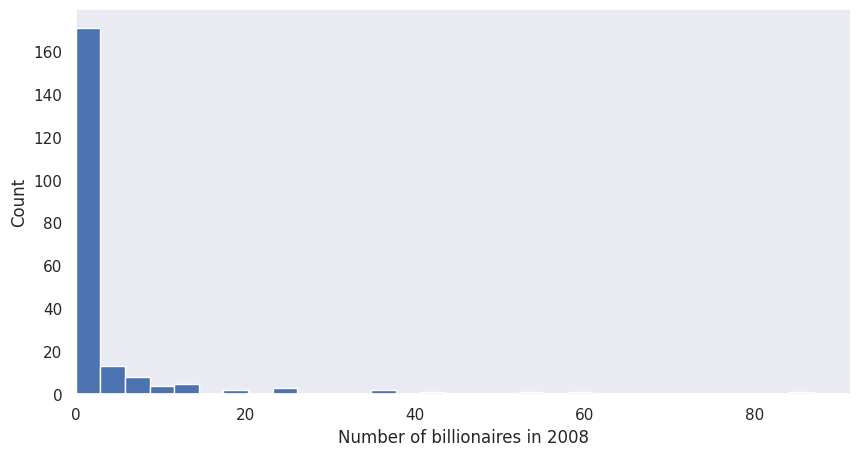

In [ ]:
numbil0_2008 = df[(df['year'] == 2008) & (
    df['country'] != 'United States')].loc[:, 'numbil0']

plt.subplots(figsize=(10, 5))
plt.hist(numbil0_2008, bins=30)
plt.xlim(left=0)
plt.grid()
plt.xlabel('Number of billionaires in 2008')
plt.ylabel('Count')
plt.show()

Из гистограммы следует, что предположение о распределении Пуассона  является разумным (хотя и с очень низким значением $ \mu $ и некоторыми выбросами).

## Условные распределения

В работе Трейсмана зависимая переменная — число миллиардеров $ y_i $ в стране $ i $ — моделируется как функция:

- ВВП на душу населения;
- численности населения;
- числа лет членства в ГАТТ и ВТО.

Итого у нас будет 4 зависимых и один свободный член — 5 параметров в сумме.

Следовательно, распределение $ y_i $ должно быть обусловлено вектором объясняющих переменных $ \mathbf{x}_i $.

Стандартная формулировка — так называемая модель *регрессии Пуассона* — выглядит следующим образом:

<a id='equation-poissonreg'></a>
$$
f(y_i \mid \mathbf{x}_i) = \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}; \qquad y_i = 0, 1, 2, \ldots , \infty ,
$$
где
$$
\mu_i
= \exp(\mathbf{x}_i' \boldsymbol{\beta})
= \exp(\beta_0 + \beta_1 x_{i1} + \ldots + \beta_k x_{ik}).
$$

Чтобы проиллюстрировать идею о том, что распределение $ y_i $ зависит от
$ \mathbf{x}_i $, давайте запустим простую симуляцию.

Мы используем нашу функцию `poisson_pmf` из вышеприведенного примера и произвольные значения для
$ \boldsymbol{\beta} $ и $ \mathbf{x}_i .$

Другими словами, мы зафиксируем $ \boldsymbol{\beta} $ и посмотрим на разные наборы данных  $\mathbf{x}_i$.

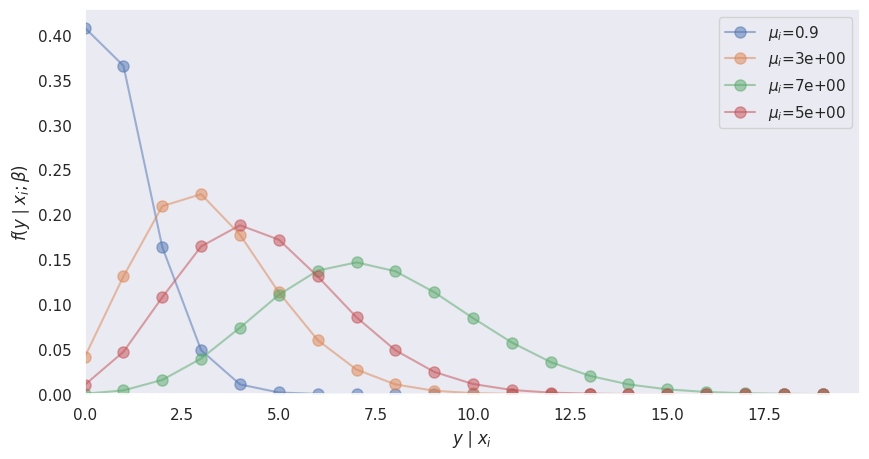

In [ ]:
y_values = range(0, 20)

# Define a parameter vector with estimates
β = np.array([0.26, 0.18, 0.25, -0.1, -0.22])

# Create some observations X
datasets = [np.array([0, 1, 1, 1, 2]),
            np.array([2, 3, 2, 4, 0]),
            np.array([3, 4, 5, 3, 2]),
            np.array([6, 5, 4, 4, 7])]


fig, ax = plt.subplots(figsize=(10, 5))

for X in datasets:
    μ = np.exp(X @ β)
    distribution = []
    for y_i in y_values:
        distribution.append(poisson_pmf(y_i, μ))
    ax.plot(y_values,
            distribution,
            label=f'$\mu_i$={μ:.1}',
            marker='o',
            markersize=8,
            alpha=0.5)

ax.grid()
ax.legend()
ax.set_xlabel('$y \mid x_i$')
ax.set_ylabel(r'$f(y \mid x_i; \beta )$')
ax.axis(xmin=0, ymin=0)
plt.show()

Мы видим, что распределение $ y_i $ условно на
$ \mathbf{x}_i $ ($ \mu_i $ больше не является константой).

## Оценка максимального правдоподобия

В нашей модели для числа миллиардеров условное распределение
содержит 4 ($ k = 4 $) параметра, которые нам нужно оценить.

Мы обозначим весь наш вектор параметров как $ \boldsymbol{\beta} $, где

$$
\boldsymbol{\beta} = \begin{bmatrix}
\beta_0 \\
\beta_1 \\
\beta_2 \\
\beta_3
\end{bmatrix}.
$$

Чтобы оценить модель с помощью MLE, мы хотим максимизировать вероятность того, что
наша оценка $ \hat{\boldsymbol{\beta}} $ является истинным параметром $ \boldsymbol{\beta} $.

Интуитивно мы хотим найти $ \hat{\boldsymbol{\beta}} $, который наилучшим образом соответствует нашим данным.

Сначала нам нужно построить функцию правдоподобия $ \mathcal{L}(\boldsymbol{\beta}) $, которая похожа на функцию плотности совместной вероятности.

Предположим, у нас есть некоторые данные $ y_i = \{y_1, y_2\} $ и
$ y_i \sim f(y_i) $.

Если $ y_1 $ и $ y_2 $ независимы, совместная pmf этих
данных равна $ f(y_1, y_2) = f(y_1) \cdot f(y_2) $.

Если $ y_i $ следует распределению Пуассона с $ \lambda = 7 $,
мы можем визуализировать совместную pmf следующим образом:

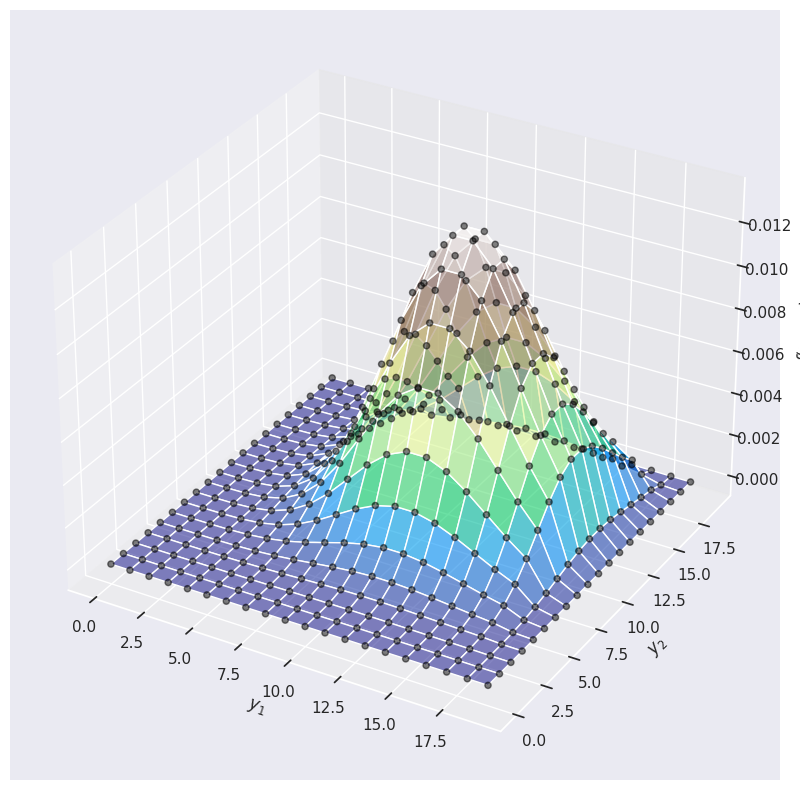

In [ ]:
def plot_joint_poisson(μ=7, y_n=20):
    yi_values = np.arange(0, y_n, 1)

    # Create coordinate points of X and Y
    X, Y = np.meshgrid(yi_values, yi_values)

    # Multiply distributions together
    Z = poisson_pmf(X, μ) * poisson_pmf(Y, μ)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z.T, cmap='terrain', alpha=0.6)
    ax.scatter(X, Y, Z.T, color='black', alpha=0.5, linewidths=1)
    ax.set(xlabel='$y_1$', ylabel='$y_2$')
    ax.set_zlabel('$f(y_1, y_2)$', labelpad=10)
    plt.show()

plot_joint_poisson(μ=12, y_n=20)

Аналогично, совместная pmf наших данных (как
условное распределение Пуассона) может быть записана как

$$
f(y_1, y_2, \ldots, y_n \mid \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n; \boldsymbol{\beta})
= \prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i};
$$

$ y_i $ условна как для значений $ \mathbf{x}_i $, так и для
параметров $ \boldsymbol{\beta} $.

Функция правдоподобия такая же, как и совместная pmf, но обрабатывает
параметр $ \boldsymbol{\beta} $ как случайную величину и принимает наблюдения
$ (y_i, \mathbf{x}_i) $ как заданные

$$
\begin{split}
\mathcal{L}(\beta \mid y_1, y_2, \ldots, y_n \ ; \ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n) = &
\prod_{i=1}^{n} \frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i} \\ = &
f(y_1, y_2, \ldots, y_n \mid \ \mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n ; \beta)
\end{split}.
$$

Теперь, когда у нас есть наша функция правдоподобия, мы хотим найти $ \hat{\boldsymbol{\beta}} $, которая дает максимальное значение правдоподобия

$$
\underset{\boldsymbol{\beta}}{\max} \mathcal{L}(\boldsymbol{\beta}).
$$

При этом обычно проще максимизировать логарифмическое правдоподобие (рассмотрите
дифференцирование $ f(x) = x \exp(x) $ против $ f(x) = \log(x) + x $).

Учитывая, что взятие логарифма является монотонным возрастающим преобразованием, максимизатор функции правдоподобия также будет максимизатором логарифмической функции правдоподобия.

В нашем случае логарифм правдоподобия равен

$$
\begin{split}
\log{ \mathcal{L}} (\boldsymbol{\beta}) = \ &
\log \Big(
f(y_1 ; \boldsymbol{\beta})
\cdot
f(y_2 ; \boldsymbol{\beta})
\cdot \ldots \cdot
f(y_n ; \boldsymbol{\beta})
\Big) \\
= &
\sum_{i=1}^{n} \log{f(y_i ; \boldsymbol{\beta})} \\
= &
\sum_{i=1}^{n}
\log \Big( {\frac{\mu_i^{y_i}}{y_i!} e^{-\mu_i}} \Big) \\
= &
\sum_{i=1}^{n} y_i \log{\mu_i} -
\sum_{i=1}^{n} \mu_i -
\sum_{i=1}^{n} \log y_i!
\end{split}
$$

MLE по $ \hat{\beta} $ можно получить, найдя

$$
\underset{\beta}{\max} \Big(
\sum_{i=1}^{n} y_i \log{exp(X_i^T\beta)} -
\sum_{i=1}^{n} exp(X_i^T\beta )  -
\sum_{i=1}^{n} \log y! \Big).
$$

Однако аналитического решения для указанной выше задачи не существует — чтобы найти MLE,
нам нужно использовать численные методы.

## MLE с численными методами

Многие распределения не имеют хороших аналитических решений и поэтому требуют
численных методов для нахождения оценок параметров.

Одним из таких численных методов является алгоритм Ньютона—Рафсона.

Наша цель — найти оценку максимального правдоподобия $ \hat{\boldsymbol{\beta}} $.

Рассмотрим такую функцию:

$$
\log \mathcal{L(\beta)} = - (\beta - 10) ^2 - 10.
$$

При оптимальном значении $ \hat{\boldsymbol{\beta}} $ первая производная функции логарифмического правдоподобия
будет равна 0:

$$
\frac{dlog \mathcal{L(\beta)}}{d \beta} = -2 (\beta-10) = 0.
$$

Давайте проиллюстрируем это:


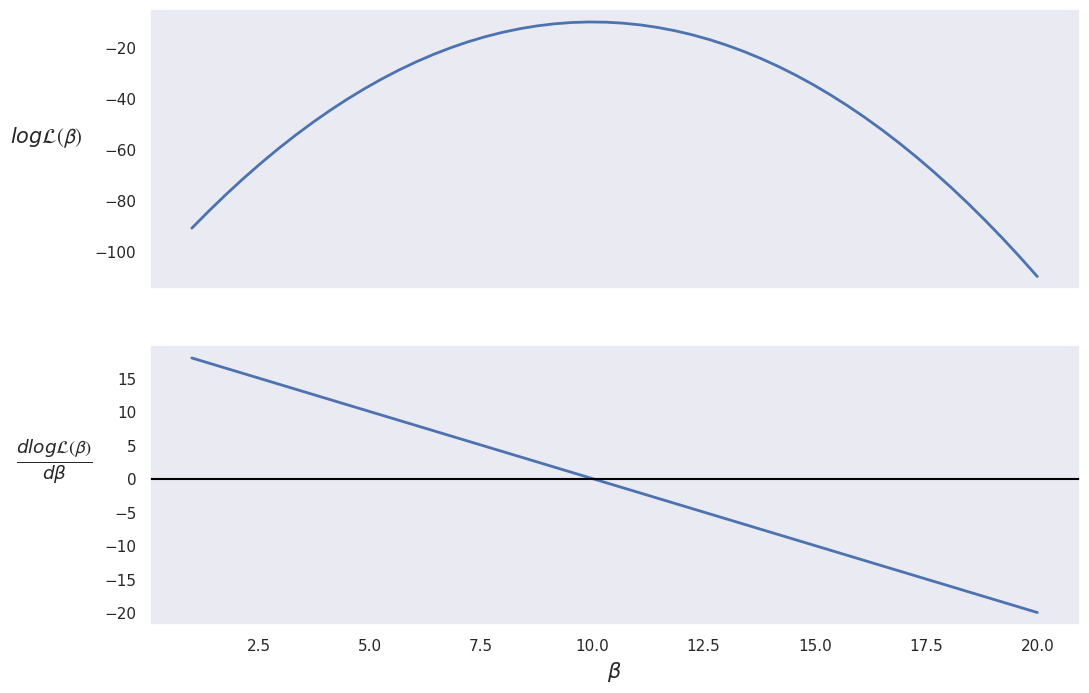

In [ ]:
β = np.linspace(1, 20)
logL = -(β - 10) ** 2 - 10
dlogL = -2 * β + 20

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(β, logL, lw=2)
ax2.plot(β, dlogL, lw=2)

ax1.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=35,
               fontsize=15)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)
ax2.set_xlabel(r'$\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

График показывает, что максимальное значение правдоподобия (верхний график) достигается,
когда $ \frac{d \log \mathcal{L(\boldsymbol{\beta})}}{d \boldsymbol{\beta}} = 0 $ (нижний график).

Следовательно, правдоподобие максимизируется, когда $ \beta = 10 $.

Мы также можем убедиться, что это значение является *максимальным* (а не
минимальным), проверив, что вторая производная (наклон нижнего графика) отрицательна.

Алгоритм [Ньютона](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) находит точку, где первая производная равна
0.

Чтобы использовать алгоритм, мы берем начальное предположение о максимальном значении,
$ \beta_0 $ (оценки параметров OLS могут быть разумным предположением), затем


- $G$ — первая производная;
- $H$ — вторая производная.

1. Используем правило обновления для итерации алгоритма:
$$
\boldsymbol{\beta}_{(k+1)} = \boldsymbol{\beta}_{(k)} - H^{-1}(\boldsymbol{\beta}_{(k)})G(\boldsymbol{\beta}_{(k)})
$$
где
$$
\begin{aligned}
G(\boldsymbol{\beta}_{(k)}) &= \frac{\partial \log \mathcal{L}(\boldsymbol{\beta}_{(k)})}{\partial \boldsymbol{\beta}_{(k)}} \\
&= \frac{\partial}{\partial \boldsymbol{\beta}_{(k)}} \left( \sum_{i=1}^{n} y_i \log{exp(X_i^T \boldsymbol{\beta})} - \sum_{i=1}^{n} exp(X_i^T \boldsymbol{\beta}) - \sum_{i=1}^{n} \log y_i! \right) \\
&= \sum_{i=1}^{n} y_i X_i^T - \sum_{i=1}^{n} X_i^T exp(X_i^T \boldsymbol{\beta}) \\
&= X^T(y - \mu),\\
H(\boldsymbol{\beta}_{(k)}) &= \frac{\partial^2 \log \mathcal{L}(\boldsymbol{\beta}_{(k)})}{\partial \boldsymbol{\beta}_{(k)} \partial \boldsymbol{\beta}_{(k)}^T} = -X^T\mu X .
\end{aligned}
$$



2. Проверяем, является ли $ \boldsymbol{\beta}_{(k+1)} - \boldsymbol{\beta}_{(k)} < tol $
- Если true, то прекращяем итерацию и устанавливаем
$ \hat{\boldsymbol{\beta}} = \boldsymbol{\beta}_{(k+1)} .$
- Если false, то обновляем $ \boldsymbol{\beta}_{(k+1)} .$

Как видно из уравнения обновления,
$ \boldsymbol{\beta}_{(k+1)} = \boldsymbol{\beta}_{(k)} ,$ только когда
$ G(\boldsymbol{\beta}_{(k)}) = 0 $ т.е. когда первая производная равна 0.

(На практике мы прекращаем итерацию, когда разница оказывается ниже небольшого
порога допуска.)

Давайте попробуем реализовать алгоритм Ньютона—Рафсона.

Сначала мы создадим класс с именем `PoissonRegression`, чтобы мы могли
легко пересчитать значения логарифма правдоподобия, градиента и гессиана
для каждой итерации.

In [ ]:
class PoissonRegression:

    def __init__(self, y, X, β):
        self.X = X
        self.n, self.k = X.shape
        # Reshape y as a n_by_1 column vector
        self.y = y.reshape(self.n,1)
        # Reshape β as a k_by_1 column vector
        self.β = β.reshape(self.k,1)

    def μ(self):
        return np.exp(self.X @ self.β)

    def logL(self):
        y = self.y
        μ = self.μ()
        return np.sum(y * np.log(μ) - μ - np.log(factorial(y)))

    def G(self):
        y = self.y
        μ = self.μ()
        return X.T @ (y - μ)

    def H(self):
        X = self.X
        μ = self.μ()
        return -(X.T @ (μ * X))

Наша функция `newton_raphson` примет объект `PoissonRegression`,
который имеет начальное предположение о векторе параметров $ \boldsymbol{\beta}_0 $.

Алгоритм обновит вектор параметров в соответствии с правилом обновления и пересчитает матрицы градиента и Гессе по новым оценкам параметров.

Итерация закончится, когда:

- Разница между параметром и обновленным параметром будет ниже допустимого уровня.
- Достигнуто максимальное количество итераций (то есть сходимость не достигнута).

Чтобы мы могли получить представление о том, что происходит во время работы алгоритма,
добавлена ​​опция `display=True` для вывода значений на каждой итерации.

In [ ]:
def newton_raphson(model, tol=1e-3, max_iter=1000, display=True):

    i = 0
    error = 100  # Initial error value

    # Print header of output
    if display:
        header = f'{"Iteration_k":<13}{"Log-likelihood":<16}{"θ":<60}'
        print(header)
        print("-" * len(header))

    # While loop runs while any value in error is greater
    # than the tolerance until max iterations are reached
    while np.any(error > tol) and i < max_iter:
        H, G = model.H(), model.G()
        β_new = model.β - (np.linalg.inv(H) @ G)
        error = np.abs(β_new - model.β)
        model.β = β_new

        # Print iterations
        if display:
            β_list = [f'{t:.3}' for t in list(model.β.flatten())]
            update = f'{i:<13}{model.logL():<16.8}{β_list}'
            print(update)

        i += 1

    print(f'Number of iterations: {i}')
    print(f'β_hat = {model.β.flatten()}')

    # Return a flat array for β (instead of a k_by_1 column vector)
    return model.β.flatten()

In [ ]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

# Take a guess at initial βs
init_β = np.array([0.1, 0.1, 0.1])

# Create an object with Poisson model values
poi = PoissonRegression(y, X, β=init_β)

# Use newton_raphson to find the MLE
β_hat = newton_raphson(poi, display=True)

Iteration_k  Log-likelihood  θ                                                           
-----------------------------------------------------------------------------------------
0            -4.3447622      ['-1.49', '0.265', '0.244']
1            -3.5742413      ['-3.38', '0.528', '0.474']
2            -3.3999526      ['-5.06', '0.782', '0.702']
3            -3.3788646      ['-5.92', '0.909', '0.82']
4            -3.3783559      ['-6.07', '0.933', '0.843']
5            -3.3783555      ['-6.08', '0.933', '0.843']
6            -3.3783555      ['-6.08', '0.933', '0.843']
Number of iterations: 7
β_hat = [-6.07848573  0.9334028   0.84329677]


Поскольку это была простая модель с небольшим количеством наблюдений, алгоритм достиг
сходимости всего за 7 итераций.

Вы можете видеть, что с каждой итерацией значение логарифмического правдоподобия увеличивалось.

Помните, нашей целью было максимизировать функцию логарифмического правдоподобия,
что и было достигнуто алгоритмом.

Также обратите внимание, что увеличение $ \log \mathcal{L}(\boldsymbol{\beta}_{(k)}) $
становится меньше с каждой итерацией.

Это происходит потому, что градиент приближается к 0 по мере достижения нами максимума,
и, следовательно, числитель в нашем уравнении обновления становится меньше.

Вектор градиента должен быть близок к 0 при $ \hat{\boldsymbol{\beta}} $

In [ ]:
poi.G()

array([[-2.52450838e-13],
       [-6.37004338e-13],
       [-4.91592878e-13]])

Итеративный процесс можно визуализировать на следующей диаграмме, где максимум достигается при $ \beta = 10 .$

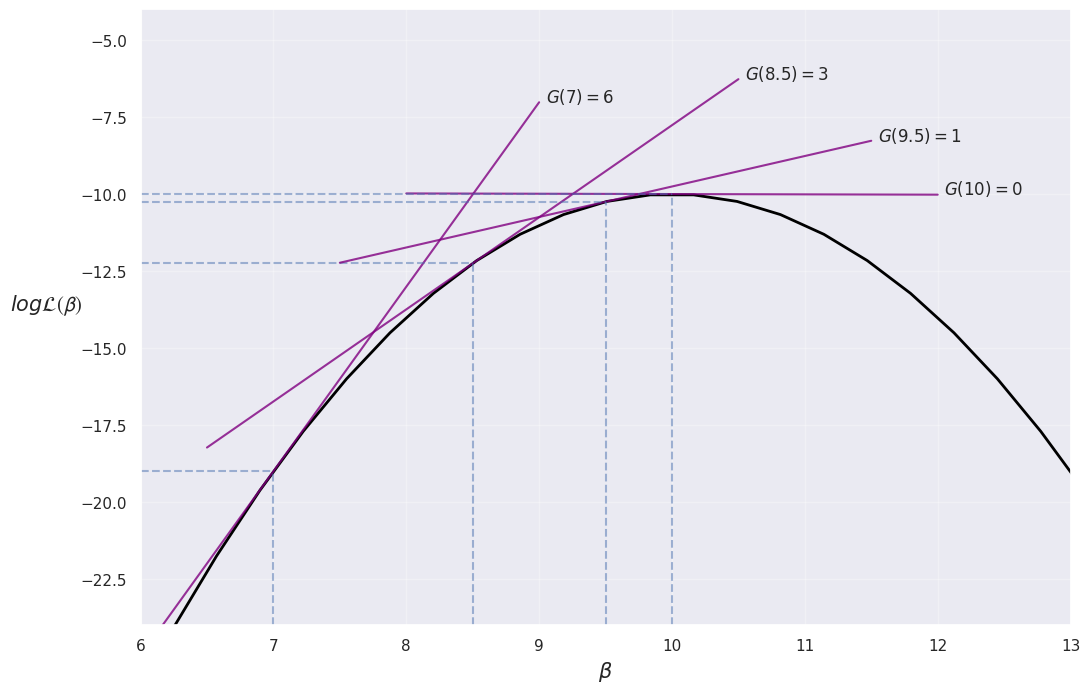

In [ ]:
logL = lambda x: -(x - 10) ** 2 - 10

def find_tangent(β, a=0.01):
    y1 = logL(β)
    y2 = logL(β+a)
    x = np.array([[β, 1], [β+a, 1]])
    m, c = np.linalg.lstsq(x, np.array([y1, y2]), rcond=None)[0]
    return m, c

β = np.linspace(2, 18)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(β, logL(β), lw=2, c='black')

for β in [7, 8.5, 9.5, 10]:
    β_line = np.linspace(β-2, β+2)
    m, c = find_tangent(β)
    y = m * β_line + c
    ax.plot(β_line, y, '-', c='purple', alpha=0.8)
    ax.text(β+2.05, y[-1], f'$G({β}) = {abs(m):.0f}$', fontsize=12)
    ax.vlines(β, -24, logL(β), linestyles='--', alpha=0.5)
    ax.hlines(logL(β), 6, β, linestyles='--', alpha=0.5)

ax.set(ylim=(-24, -4), xlim=(6, 13))
ax.set_xlabel(r'$\beta$', fontsize=15)
ax.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=25,
               fontsize=15)
ax.grid(alpha=0.3)
plt.show()

## Оценка методом максимального правдоподобия с использованием `statsmodels`

Теперь, когда мы понимаем, что происходит под капотом, мы можем применить MLE к интересному приложению.

Мы будем использовать модель пуассоновской регрессии в `statsmodels`, чтобы получить более богатый вывод со стандартными ошибками, тестовыми значениями и другими данными.

`statsmodels` использует тот же алгоритм, что и выше, для нахождения оценок максимального правдоподобия.

Прежде чем начать, давайте переоценим нашу простую модель с помощью `statsmodels`, чтобы убедиться, что мы получаем те же коэффициенты и значение логарифмического правдоподобия.

In [ ]:
X = np.array([[1, 2, 5],
              [1, 1, 3],
              [1, 4, 2],
              [1, 5, 2],
              [1, 3, 1]])

y = np.array([1, 0, 1, 1, 0])

stats_poisson = Poisson(y, X).fit()
print(stats_poisson.summary())

Optimization terminated successfully.
         Current function value: 0.675671
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:                      y   No. Observations:                    5
Model:                        Poisson   Df Residuals:                        2
Method:                           MLE   Df Model:                            2
Date:                Sun, 13 Oct 2024   Pseudo R-squ.:                  0.2546
Time:                        18:54:12   Log-Likelihood:                -3.3784
converged:                       True   LL-Null:                       -4.5325
Covariance Type:            nonrobust   LLR p-value:                    0.3153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0785      5.279     -1.151      0.250     -16.425       4.268
x1             0.9334      0.

Теперь давайте воспроизведем результаты из статьи Даниэля Трейсмана [Российские миллиардеры](https://www.aeaweb.org/articles?id=10.1257/aer.p20161068), упомянутой ранее.

Трейсман начинает с оценки уравнения, где:

- $ y_i $ — это $ {количество\ миллиардеров}_i $
- $ x_{i1} $ — это $ \log{ВВП\ на\ душу\ населения}_i $
- $ x_{i2} $ — это $ \log{население}_i $
- $ x_{i3} $ — это $ {годы\ в\ ГАТТ}_i $ — годы членства в ГАТТ и ВТО (для прокси-доступа к международным рынкам)

В статье рассматривается только 2008 год для оценки.

In [ ]:
# Keep only year 2008
df = df[df['year'] == 2008]

# Add a constant
df['const'] = 1

# Variable sets
reg1 = ['const', 'lngdppc', 'lnpop', 'gattwto08']
reg2 = ['const', 'lngdppc', 'lnpop',
        'gattwto08', 'lnmcap08', 'rintr', 'topint08']
reg3 = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08',
        'rintr', 'topint08', 'nrrents', 'roflaw']

In [ ]:
# Specify model
poisson_reg = sm.Poisson(df[['numbil0']], df[reg1],
                         missing='drop').fit(cov_type='HC0')
print(poisson_reg.summary())

Optimization terminated successfully.
         Current function value: 2.226090
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:                numbil0   No. Observations:                  197
Model:                        Poisson   Df Residuals:                      193
Method:                           MLE   Df Model:                            3
Date:                Sun, 13 Oct 2024   Pseudo R-squ.:                  0.8574
Time:                        18:55:47   Log-Likelihood:                -438.54
converged:                       True   LL-Null:                       -3074.7
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.0495      2.578    -11.268      0.000     -34.103     -23.997
lngdppc        1.0839      0.

In [ ]:
regs = [reg1, reg2, reg3]
reg_names = ['Model 1', 'Model 2', 'Model 3']
info_dict = {'Pseudo R-squared': lambda x: f"{x.prsquared:.2f}",
             'No. observations': lambda x: f"{int(x.nobs):d}"}
regressor_order = ['const',
                   'lngdppc',
                   'lnpop',
                   'gattwto08',
                   'lnmcap08',
                   'rintr',
                   'topint08',
                   'nrrents',
                   'roflaw']
results = []

for reg in regs:
    result = sm.Poisson(df[['numbil0']], df[reg],
                        missing='drop').fit(cov_type='HC0',
                                            maxiter=100, disp=0)
    results.append(result)

results_table = summary_col(results=results,
                            float_format='%0.3f',
                            stars=True,
                            model_names=reg_names,
                            info_dict=info_dict,
                            regressor_order=regressor_order)
results_table.add_title('Table 1 - Explaining the Number of Billionaires \
                        in 2008')
print(results_table)

Table 1 - Explaining the Number of Billionaires                         in 2008
                  Model 1    Model 2    Model 3  
-------------------------------------------------
const            -29.050*** -19.444*** -20.858***
                 (2.578)    (4.820)    (4.255)   
lngdppc          1.084***   0.717***   0.737***  
                 (0.138)    (0.244)    (0.233)   
lnpop            1.171***   0.806***   0.929***  
                 (0.097)    (0.213)    (0.195)   
gattwto08        0.006      0.007      0.004     
                 (0.007)    (0.006)    (0.006)   
lnmcap08                    0.399**    0.286*    
                            (0.172)    (0.167)   
rintr                       -0.010     -0.009    
                            (0.010)    (0.010)   
topint08                    -0.051***  -0.058*** 
                            (0.011)    (0.012)   
nrrents                                -0.005    
                                       (0.010)   
roflaw              

Вывод предполагает, что частота миллиардеров положительно коррелирует с ВВП на душу населения, размером населения, капитализацией фондового рынка и отрицательно коррелирует с максимальной ставкой подоходного налога.

Чтобы проанализировать наши результаты по странам, мы можем построить график разницы между прогнозируемыми и фактическими значениями, затем отсортировать их от наибольшего к наименьшему и построить график первых 15 значений.

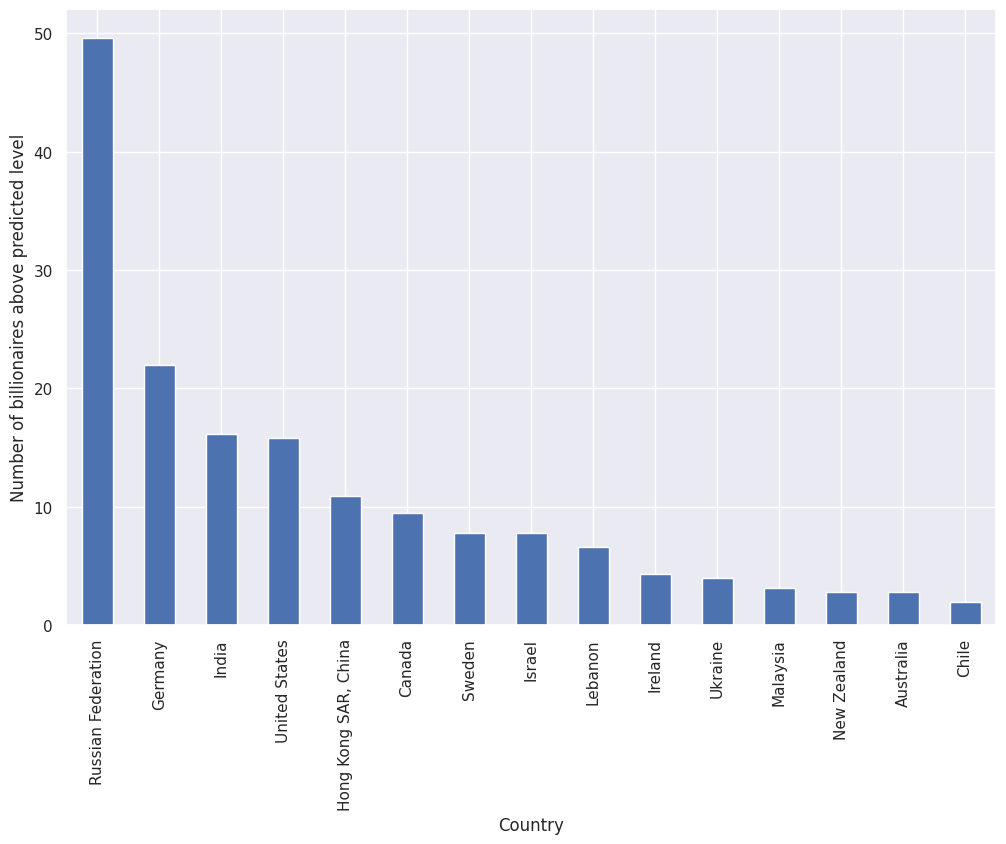

In [ ]:
data = ['const', 'lngdppc', 'lnpop', 'gattwto08', 'lnmcap08', 'rintr',
        'topint08', 'nrrents', 'roflaw', 'numbil0', 'country']
results_df = df[data].dropna()

# Use last model (model 3)
results_df['prediction'] = results[-1].predict()

# Calculate difference
results_df['difference'] = results_df['numbil0'] - results_df['prediction']

# Sort in descending order
results_df.sort_values('difference', ascending=False, inplace=True)

# Plot the first 15 data points
results_df[:15].plot('country', 'difference', kind='bar',
                    figsize=(12,8), legend=False)
plt.ylabel('Number of billionaires above predicted level')
plt.xlabel('Country')
plt.show()

Как мы видим, Россия имеет намного большее количество миллиардеров, чем предсказывает модель (примерно на 50 больше, чем ожидалось).

Трейсман использует этот эмпирический результат для обсуждения возможных причин избыточного количества миллиардеров в России, включая происхождение богатства в России, политический климат и историю приватизации в годы после СССР.

## Резюме

В этом семинаре мы использовали оценку методом максимального правдоподобия для оценки параметров модели Пуассона.

`statsmodels` содержит другие встроенные модели правдоподобия, такие как [Probit](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Probit.html) и [Logit](https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html).

Для большей гибкости `statsmodels` предоставляет способ указать распределение вручную с помощью класса `GenericLikelihoodModel` — пример ноутбука можно найти [здесь](https://www.statsmodels.org/dev/examples/notebooks/generated/generic_mle.html).

# Домашнее задание 2

Построить пуассоновскую регрессию с помощью pytorch.

Решением задания будет код.

Задание будет оцениваться по следующим критериям:

- код выполняется без ошибок;
- код решает задачу и полученные коэффециенты сопоставимы с теми, что получены с помощью statmodels. Для решения используем параметры reg2, описанные выше.